<a href="https://colab.research.google.com/github/halcy/LearningJAX/blob/main/JAX_Day_2_Morning_Parallel_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# JAX Day 2 - Morning - MNIST, but fast

Lets combine our knowledge of how to go wide with the MNIST classifier and train one real fast like. (*)

*: The model is honestly quite small, so if the speedup to be expected is minimal, if even present at all.

In [ ]:
# Catchall "what is this runtime" cell
!nvidia-smi
GPU = !nvidia_smi

if len(GPU) > 3:
    GPU = True
else:
    GPU = False

!vmstat
print("")

import os

if "COLAB_TPU_ADDR" in os.environ:
    from tensorflow.python.profiler import profiler_client
    print("tpu:", os.environ['COLAB_TPU_ADDR'])
    tpu_profile_service_address = os.environ['COLAB_TPU_ADDR'].replace('8470', '8466')
    print(profiler_client.monitor(tpu_profile_service_address, 100, 2).strip())
    TPU = True
else:
    print("tpu: no")
    TPU = False

CPUS = os.cpu_count()
print("\ncpus:", CPUS)

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.

procs -----------memory---------- ---swap-- -----io---- -system-- ------cpu-----
 r  b   swpd   free   buff  cache   si   so    bi    bo   in   cs us sy id wa st
 0  0      0 10232360 108240 2445160    0    0   669    39 2167 8461  3  3 92  1  0

tpu: 10.101.203.26:8470
Timestamp: 11:00:48
  TPU type: TPU v2
  Utilization of TPU Matrix Units (higher is better): 0.000%

cpus: 2


# Basic setup and data loading

You know the deal by now, jax, haiku, optax, xmap / mesh, MNIST loading.

In [ ]:
# Set JAX, haiku and optax up for the TPU
!pip install --upgrade -q jax jaxlib dm-haiku optax tqdm

import requests
import os

if 'TPU_DRIVER_MODE' not in globals():
    url = 'http://' + os.environ['COLAB_TPU_ADDR'].split(':')[0] + ':8475/requestversion/tpu_driver_nightly'
    resp = requests.post(url)
    TPU_DRIVER_MODE = 1

# TPU driver as backend for JAX
from jax.config import config
config.FLAGS.jax_xla_backend = "tpu_driver"
config.FLAGS.jax_backend_target = "grpc://" + os.environ['COLAB_TPU_ADDR']

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

import jax
import jax.numpy as jnp
from jax import jit, nn

from jax.experimental.maps import xmap, mesh
from jax.experimental.pjit import pjit, PartitionSpec

import haiku as hk
import optax

import tqdm

# Pinky promise: We are now aware xmap is experimental, and will adjust our expectations accordingly
import warnings
warnings.filterwarnings("ignore", message="xmap is an experimental feature and probably has bugs!")

In [ ]:
# Generate PRNG state
prng = jax.random.PRNGKey(23)

In [ ]:
# Lets get MNIST
import tensorflow_datasets as tfds

data_dir = '/tmp/tfds'

# Fetch full datasets for evaluation
mnist_data, info = tfds.load(name="mnist", batch_size=-1, data_dir=data_dir, with_info=True)
mnist_data = tfds.as_numpy(mnist_data)
train_data, test_data = mnist_data['train'], mnist_data['test']
num_labels = info.features['label'].num_classes
h, w, c = info.features['image'].shape
num_pixels = h * w * c

# Full train set
train_images, train_labels = train_data['image'], train_data['label']
train_labels = nn.one_hot(train_labels, num_labels)
train_images = jnp.array(train_images.astype(jnp.float32)) # One change here: We're explicitly converting to a jax array

# Full test set
test_images, test_labels = test_data['image'], test_data['label']
test_labels = nn.one_hot(test_labels, num_labels)
test_images = jnp.array(test_images.astype(jnp.float32)) # Same here

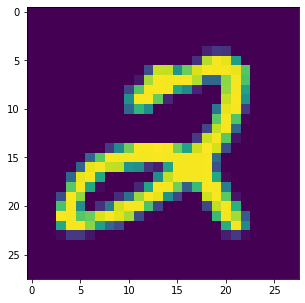

In [ ]:
plt.figure(figsize=(5, 5))
plt.imshow(test_images[0,:,:,0], interpolation=None)

# Classifier, now parallelism capable

We don't have to change a whole lot about the classifier, we just need to change some operations in the network, and the loss function to use the named "batch" axis.

In [ ]:
# Lets define a network
class ResBlock(hk.Module):
    def __call__(self, x):
        conv1 = hk.Conv2D(7, (3, 3))
        conv2 = hk.Conv2D(5, (5, 5))
        conv3 = hk.Conv2D(1, (7, 7))
        
        x_in = x
        x = jax.nn.relu(conv1(x))
        x = jax.nn.relu(conv2(x))
        x = jax.nn.relu(conv3(x))
        x = hk.max_pool(x, (3, 3, 1), 1, 'SAME') # Taking the batch axis out here. It was optional needed to begin with.
        x = x - x_in

        return x + w

# "idk, a resnet?"
def network(x, is_training=True):
    block1 = ResBlock()
    bn1 = hk.BatchNorm(True, True, 0.999, axis=["batch", 0, 1]) # These need to explicitly be told the batch axis exists

    block2 = ResBlock()
    bn2 = hk.BatchNorm(True, True, 0.999, axis=["batch", 0, 1])
    
    block3 = ResBlock()
    bn3 = hk.BatchNorm(True, True, 0.999, axis=["batch", 0, 1])
    
    project = hk.Linear(num_labels)
    x = block1(x)
    x = bn1(x, is_training)

    x = block2(x)
    x = bn2(x, is_training)

    x = block3(x)
    x = bn3(x, is_training)

    x = x.reshape(-1, num_pixels)
    x = project(x)
    return x

In [ ]:
# Some parameters
batch_size = 1024 * 8 # Since we're now running in parallel, lets go proper wide
learning_rate = 0.0001
train_epochs = 250

In [ ]:
# Construct a model and optimizer
model = hk.transform_with_state(network)
opt = optax.chain(
    optax.scale_by_adam(b1=0.9, b2=0.999, eps=1e-8),
    optax.scale(-learning_rate)
)

In [ ]:
# Init model and optimizer parameters
params, state = xmap(lambda x: model.init(prng, x), [["batch", ...]], [...])(train_images[:1, :, :, :])
opt_params = opt.init(params)

In [ ]:
# Define a loss function
def loss_fn(params, state, x, y):
    x, state = model.apply(params, state, None, x, is_training=True)
    x = nn.log_softmax(x)
    loss = -jnp.mean(x * y) # Explicitly tell the loss function to calculate mean over batch _and_ outputs
    #loss = loss.reshape(()) # Eliminate all axes
    loss = jnp.mean(loss, axis="batch")
    return loss, (loss, state)

In [ ]:
# To demonstrate: We can now calculate loss over all TPUs!
in_axes = [
    [...],            # Axes for params: None, really
    [...],            # Axes for state: Same
    ["batch", ...],   # Axes for x: batches, rest
    ["batch", ...],   # Axes for y: Same
]
out_axes = [...]

loss_fn_xmap = xmap(loss_fn, in_axes, out_axes, axis_resources={'batch': 'batch_tpus'})

with mesh(jax.devices(), ('batch_tpus',)):
    loss, (loss2, state) = loss_fn_xmap(params, state, train_images[:16,:,:,:], train_labels[:16, :])
loss

ShardedDeviceArray(0.26708156, dtype=float32)

# Training loop

Changes here: 
  * One batch is ran via xmap (in train_step)
  * jit(xmap()) doesn't work - xmap with empty axes specifications is equivalent, and does!
  * We use jax.lax.fori_loop to keep syncing with the host to a minimum

In [ ]:
# Train step now runs the loss function via xmap
def train_step(params, state, opt_params, x, y):
    grad, (loss, state) = jax.grad(loss_fn_xmap, has_aux=True)(params, state, x, y)
    updates, opt_params = opt.update(grad, opt_params, params)
    params = optax.apply_updates(params, updates)
    return params, state, opt_params, loss

"""
# The step is still jit-ed (but now we have to use xmap - jit() won't work!)
train_step = xmap(train_step, [...], [...])

def train_epoch(params, state, opt_params):
    losses = []
    for batch in jnp.arange(0, len(train_images), batch_size):
        x = train_images[batch:batch+batch_size,:,:,:]
        y = train_labels[batch:batch+batch_size,:]
        params, state, opt_params, loss = train_step(params, state, opt_params, x, y)
        losses.append(loss)
    return params, state, opt_params, losses
"""

# Alternately, we can convert to run the training epoch with fori_loop
def train_epoch(params, state, opt_params):
    losses = jnp.zeros(int(len(train_images) // batch_size))
    epoch_state = (params, state, opt_params, losses)
    def train_step_internal(idx, epoch_state, train_images, train_labels):
        (params, state, opt_params, losses) = epoch_state
        batch = idx * batch_size
        x = jax.lax.dynamic_slice(train_images, [batch, 0, 0, 0], [batch_size, 28, 28, 1])  # We have to use dynamic_slice, numpy style indexing won't work
        y = jax.lax.dynamic_slice(train_labels, [batch, 0], [batch_size, 10])
        params, state, opt_params, loss = train_step(params, state, opt_params, x, y)
        loss = jnp.array(loss).reshape(1,)
        losses = jax.lax.dynamic_update_slice(losses, loss, (idx,)) # Similarly, we have to store our losses using dynamic_update_slice
        state_out = (params, state, opt_params, losses)
        return state_out

    params, state, opt_params, losses = jax.lax.fori_loop(0, int(len(train_images) // batch_size), lambda i, x: train_step_internal(i, x, train_images, train_labels), epoch_state)
    return params, state, opt_params, losses

# Now, jit-ing the whole epoch is sensible - note that we actually _have_ to do this, otherwise fori_loop will
# cause our devices to disappear the same way jit() does
train_epoch = xmap(train_epoch, [...], [...])

# We have to use the context manager to make ressources available
with mesh(jax.devices(), ('batch_tpus',)):
    for step in range(train_epochs):
        losses = []
        params, state, opt_params, losses = train_epoch(params, state, opt_params)
        print("e:", step, "l:", np.mean(losses))

e: 0 l: 0.2631526
e: 1 l: 0.24863295
e: 2 l: 0.23483178
e: 3 l: 0.22201818
e: 4 l: 0.21049435
e: 5 l: 0.20028307
e: 6 l: 0.19113491
e: 7 l: 0.18286307
e: 8 l: 0.17540398
e: 9 l: 0.16870299
e: 10 l: 0.16270956
e: 11 l: 0.15743463
e: 12 l: 0.15285432
e: 13 l: 0.1489542
e: 14 l: 0.14570253
e: 15 l: 0.14314955
e: 16 l: 0.14132613
e: 17 l: 0.14009792
e: 18 l: 0.139308
e: 19 l: 0.13839132
e: 20 l: 0.13715398
e: 21 l: 0.13572226
e: 22 l: 0.13436827
e: 23 l: 0.13332886
e: 24 l: 0.13271955
e: 25 l: 0.13179249
e: 26 l: 0.13086204
e: 27 l: 0.12961625
e: 28 l: 0.12844354
e: 29 l: 0.12669142
e: 30 l: 0.12510127
e: 31 l: 0.1243893
e: 32 l: 0.12527484
e: 33 l: 0.1288429
e: 34 l: 0.13228595
e: 35 l: 0.133617
e: 36 l: 0.14205822
e: 37 l: 0.15140454
e: 38 l: 0.14901148
e: 39 l: 0.1418332
e: 40 l: 0.1323016
e: 41 l: 0.12208067
e: 42 l: 0.113537036
e: 43 l: 0.10728891
e: 44 l: 0.10258477
e: 45 l: 0.0987932
e: 46 l: 0.09514723
e: 47 l: 0.092318855
e: 48 l: 0.08996953
e: 49 l: 0.08771874
e: 50 l: 0.08602314

# Evaluation
Largely as before, just need to make sure batch axis exists.

In [ ]:
in_axes = [
    [...],            # Axes for params: None, really
    [...],            # Axes for state: Same
    [...],            # Axes for prng: Same
    ["batch", ...],   # Axes for x: batches, rest
]
out_axes = [
    ["batch", ...],
    ["batch", ...]
]
test_pred, _ = xmap(lambda x, y, z, w: model.apply(x, y, z, w, is_training=False), in_axes, out_axes)(params, state, None, test_images)

In [ ]:
print("accuracy:", np.mean((np.argmax(test_pred, axis = -1) - np.argmax(test_labels, axis = -1)) == 0))

accuracy: 0.09787042
